In [28]:
# If needed, first install yfinance:
# pip install yfinance pandas

import yfinance as yf

# ETFs and date range
tickers = ["IWP", "IWS", "IWR"]
start = "2002-01-01"
end = "2024-12-31"

# Download each ETF separately and save as its own CSV file
for t in tickers:
    print(f"Downloading {t} ...")
    data = yf.download(t, start=start, end=end, progress=False, auto_adjust=False)
    data.index.name = "Date"
    filename = f"{t}_2002_2024.csv"
    data.to_csv(filename)
    print(f"✅ Saved {filename}")

print("All CSV files downloaded successfully!")

✅ Saved IWP_2002_2024.csv
✅ Saved IWS_2002_2024.csv
✅ Saved IWR_2002_2024.csv
All CSV files downloaded successfully!


In [29]:
import pandas as pd
from pathlib import Path

# Peek at the uploaded CSVs to detect their structure
paths = [Path("/content/IWP_2002_2024.csv"), Path("/content/IWS_2002_2024.csv"), Path("/content/IWR_2002_2024.csv")]
info = {}

for p in paths:
    # Try reading normally first
    df1 = pd.read_csv(p, nrows=5)
    cols1 = list(df1.columns)
    # Try reading with index_col=0
    df2 = pd.read_csv(p, nrows=5, index_col=0)
    cols2 = list(df2.columns)
    info[str(p)] = {"read_columns": cols1, "read_index0_columns": cols2, "head_sample": df1.head().to_dict()}

info


{'/content/IWP_2002_2024.csv': {'read_columns': ['Price',
   'Adj Close',
   'Close',
   'High',
   'Low',
   'Open',
   'Volume'],
  'read_index0_columns': ['Adj Close',
   'Close',
   'High',
   'Low',
   'Open',
   'Volume'],
  'head_sample': {'Price': {0: 'Ticker',
    1: 'Date',
    2: '2002-01-02',
    3: '2002-01-03',
    4: '2002-01-04'},
   'Adj Close': {0: 'IWP',
    1: nan,
    2: '15.152287483215332',
    3: '15.338377952575684',
    4: '15.492753982543945'},
   'Close': {0: 'IWP',
    1: nan,
    2: '17.912500381469727',
    3: '18.13249969482422',
    4: '18.315000534057617'},
   'High': {0: 'IWP',
    1: nan,
    2: '17.940000534057617',
    3: '18.167499542236328',
    4: '18.375'},
   'Low': {0: 'IWP',
    1: nan,
    2: '17.72249984741211',
    3: '17.950000762939453',
    4: '18.052499771118164'},
   'Open': {0: 'IWP',
    1: nan,
    2: '17.940000534057617',
    3: '17.950000762939453',
    4: '18.375'},
   'Volume': {0: 'IWP', 1: nan, 2: '11600', 3: '19600', 4: '34

In [30]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

DATA_DIR = Path("/content")
TICKERS = ["IWP", "IWS", "IWR"]
INPUT_FILES = {t: DATA_DIR / f"{t}_2002_2024.csv" for t in TICKERS}

def load_clean_generic(path: Path) -> pd.DataFrame:
    """Load CSVs that may have a two-row header (with 'Price'/'Date' pattern) or standard yfinance format."""
    df = pd.read_csv(path)
    cols = list(df.columns)
    # Case A: two-row header dumped from Yahoo UI (Price column holds 'Ticker', 'Date', then dates)
    if "Price" in cols and "Adj Close" in cols and len(df) > 2:
        first_two = df["Price"].astype(str).iloc[:2].tolist()
        if first_two[0].lower() == "ticker" and first_two[1].lower() == "date":
            df = df.iloc[2:].copy()  # drop the two header rows
            df.rename(columns={"Price": "Date"}, inplace=True)
            # Convert types
            df["Date"] = pd.to_datetime(df["Date"])
            # Ensure numeric
            for c in ["Adj Close", "Close", "High", "Low", "Open", "Volume"]:
                if c in df.columns:
                    df[c] = pd.to_numeric(df[c], errors="coerce")
            # Keep the essentials
            return df[["Date", "Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)
    # Case B: standard yfinance
    if "Date" in cols and "Adj Close" in cols:
        df["Date"] = pd.to_datetime(df["Date"])
        return df[["Date", "Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)
    # Case C: Date is index
    try:
        df2 = pd.read_csv(path, index_col=0)
        df2.index = pd.to_datetime(df2.index)
        if "Adj Close" in df2.columns:
            out = df2[["Adj Close"]].copy()
            out = out.reset_index().rename(columns={"index": "Date"})
            return out[["Date", "Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)
    except Exception:
        pass
    raise ValueError(f"Unrecognized format for {path}")

def compute_yearwise_buy_hold(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["Year"] = df["Date"].dt.year
    firsts = df.groupby("Year").first().rename(columns={"Date": "FirstDate", "Adj Close": "FirstAdjClose"})
    lasts  = df.groupby("Year").last().rename(columns={"Date": "LastDate",  "Adj Close": "LastAdjClose"})
    out = firsts[["FirstDate", "FirstAdjClose"]].join(lasts[["LastDate", "LastAdjClose"]])
    out = out.dropna().reset_index()
    out["AnnualReturn"] = (out["LastAdjClose"] / out["FirstAdjClose"]) - 1.0
    # Wealth metrics (100 reset and cumulative reinvest)
    STARTING_CAPITAL = 100
    out["EndWealth_if_10k_start"] = STARTING_CAPITAL * (1 + out["AnnualReturn"])
    wealth = STARTING_CAPITAL
    cum_wealth = []
    for r in out["AnnualReturn"]:
        wealth = wealth * (1 + r)
        cum_wealth.append(wealth)
    out["Cumulative_Wealth_from_10k"] = cum_wealth
    return out

# Test loader and compute for one file to validate
samples = {}
for t in TICKERS:
    df = load_clean_generic(INPUT_FILES[t])
    samples[t] = df.head(3).to_dict()

samples


{'IWP': {'Date': {0: Timestamp('2002-01-02 00:00:00'),
   1: Timestamp('2002-01-03 00:00:00'),
   2: Timestamp('2002-01-04 00:00:00')},
  'Adj Close': {0: 15.152287483215332,
   1: 15.338377952575684,
   2: 15.492753982543944}},
 'IWS': {'Date': {0: Timestamp('2002-01-02 00:00:00'),
   1: Timestamp('2002-01-03 00:00:00'),
   2: Timestamp('2002-01-04 00:00:00')},
  'Adj Close': {0: 16.003925323486328,
   1: 16.082351684570312,
   2: 16.25775909423828}},
 'IWR': {'Date': {0: Timestamp('2002-01-02 00:00:00'),
   1: Timestamp('2002-01-03 00:00:00'),
   2: Timestamp('2002-01-04 00:00:00')},
  'Adj Close': {0: 10.17330551147461,
   1: 10.316862106323242,
   2: 10.439409255981444}}}

# Annual

In [31]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("/content")
OUT_DIR = DATA_DIR / "buy_and_hold_yearly"
OUT_DIR.mkdir(exist_ok=True, parents=True)

TICKERS = ["IWP", "IWS", "IWR"]

def load_clean_generic(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "Price" in df.columns and "Adj Close" in df.columns:
        if len(df) > 2 and str(df["Price"].iloc[0]).lower() == "ticker" and str(df["Price"].iloc[1]).lower() == "date":
            df = df.iloc[2:].copy()
            df.rename(columns={"Price": "Date"}, inplace=True)
            df["Date"] = pd.to_datetime(df["Date"])
            for c in ["Adj Close", "Close", "High", "Low", "Open", "Volume"]:
                if c in df.columns:
                    df[c] = pd.to_numeric(df[c], errors="coerce")
            return df[["Date", "Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)
    if "Date" in df.columns and "Adj Close" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        return df[["Date", "Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)
    df2 = pd.read_csv(path, index_col=0)
    df2.index = pd.to_datetime(df2.index)
    if "Adj Close" in df2.columns:
        out = df2[["Adj Close"]].copy().reset_index().rename(columns={"index": "Date"})
        return out[["Date", "Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)
    raise ValueError(f"Unrecognized format for {path}")

def compute_yearwise_buy_hold(df: pd.DataFrame, starting_capital: float = 100) -> pd.DataFrame:
    df = df.copy()
    df["Year"] = df["Date"].dt.year
    firsts = df.groupby("Year").first().rename(columns={"Date": "FirstDate", "Adj Close": "FirstAdjClose"})
    lasts  = df.groupby("Year").last().rename(columns={"Date": "LastDate",  "Adj Close": "LastAdjClose"})
    out = firsts[["FirstDate", "FirstAdjClose"]].join(lasts[["LastDate", "LastAdjClose"]]).dropna().reset_index()
    out["AnnualReturn"] = (out["LastAdjClose"] / out["FirstAdjClose"]) - 1.0
    out["EndWealth_if_10k_start"] = starting_capital * (1 + out["AnnualReturn"])
    wealth = starting_capital
    cum = []
    for r in out["AnnualReturn"]:
        wealth *= (1 + r)
        cum.append(wealth)
    out["Cumulative_Wealth_from_10k"] = cum
    return out

# Build per-ticker outputs and a combined summary
per_ticker = {}
for t in TICKERS:
    path = DATA_DIR / f"{t}_2002_2024.csv"
    d = load_clean_generic(path)
    res = compute_yearwise_buy_hold(d)
    res.insert(1, "Ticker", t)
    out_path = OUT_DIR / f"{t}_buy_and_hold_yearly_2002_2024.csv"
    res.to_csv(out_path, index=False)
    per_ticker[t] = res

# Combined table
combined = pd.concat(per_ticker.values(), ignore_index=True)
combined = combined[
    ["Ticker", "Year", "FirstDate", "FirstAdjClose", "LastDate", "LastAdjClose",
     "AnnualReturn", "EndWealth_if_10k_start", "Cumulative_Wealth_from_10k"]
]
# Format columns
num_cols = ["FirstAdjClose", "LastAdjClose", "AnnualReturn", "EndWealth_if_10k_start", "Cumulative_Wealth_from_10k"]
combined[num_cols] = combined[num_cols].apply(pd.to_numeric, errors="coerce")
combined["AnnualReturn"] = (combined["AnnualReturn"]*100).round(2)
for c in ["FirstAdjClose", "LastAdjClose", "EndWealth_if_10k_start", "Cumulative_Wealth_from_10k"]:
    combined[c] = combined[c].round(2)

combined_path = OUT_DIR / "IWP_IWS_IWR_buy_and_hold_yearly_2002_2024.csv"
combined.to_csv(combined_path, index=False)

# ✅ Display results
print("✅ Year-wise Buy & Hold Summary (first 10 rows):")
print(combined.head(10))
print(f"\nCombined CSV saved at: {combined_path}")


✅ Year-wise Buy & Hold Summary (first 10 rows):
  Ticker  Year  FirstDate  FirstAdjClose   LastDate  LastAdjClose  \
0    IWP  2002 2002-01-02          15.15 2002-12-31         10.95   
1    IWP  2003 2003-01-02          11.36 2003-12-31         15.64   
2    IWP  2004 2004-01-02          15.55 2004-12-31         17.99   
3    IWP  2005 2005-01-03          17.70 2005-12-30         20.10   
4    IWP  2006 2006-01-03          20.46 2006-12-29         22.22   
5    IWP  2007 2007-01-03          22.21 2007-12-31         24.72   
6    IWP  2008 2008-01-02          24.38 2008-12-31         13.70   
7    IWP  2009 2009-01-02          14.31 2009-12-31         20.06   
8    IWP  2010 2010-01-04          20.35 2010-12-31         25.29   
9    IWP  2011 2011-01-03          25.58 2011-12-30         24.82   

   AnnualReturn  EndWealth_if_10k_start  Cumulative_Wealth_from_10k  
0        -27.76                   72.24                       72.24  
1         37.67                  137.67             

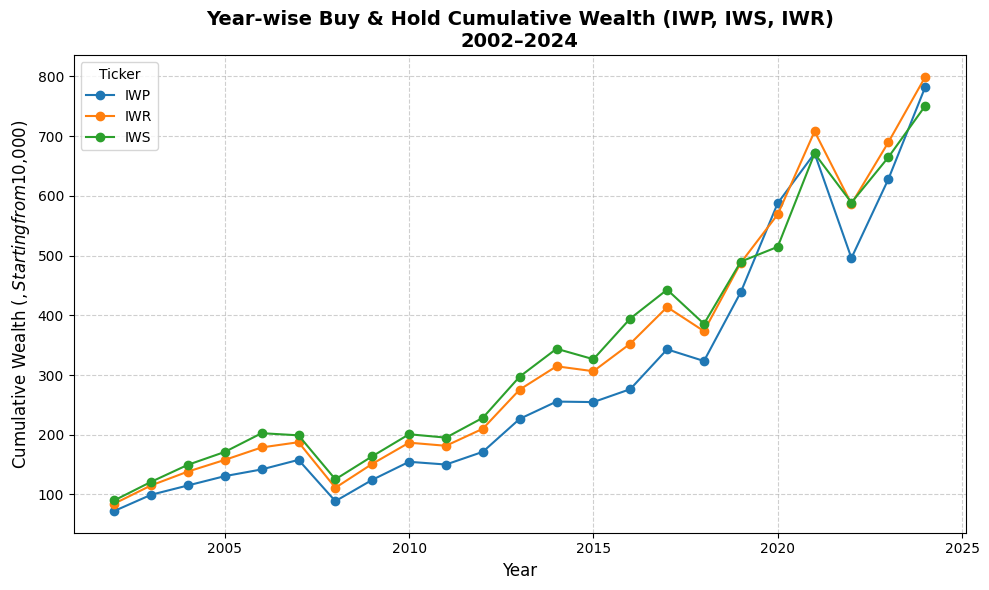

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---- Load the combined Buy & Hold results ----
combined_path = Path("/content/buy_and_hold_yearly/IWP_IWS_IWR_buy_and_hold_yearly_2002_2024.csv")
df = pd.read_csv(combined_path)

# ---- Convert dates properly ----
df["Year"] = df["Year"].astype(int)
df = df.sort_values(["Ticker", "Year"])

# ---- Plot cumulative wealth ----
plt.figure(figsize=(10,6))

for ticker in df["Ticker"].unique():
    data = df[df["Ticker"] == ticker]
    plt.plot(data["Year"], data["Cumulative_Wealth_from_10k"], marker='o', label=ticker)

# ---- Graph formatting ----
plt.title("Year-wise Buy & Hold Cumulative Wealth (IWP, IWS, IWR)\n2002–2024", fontsize=14, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cumulative Wealth ($, Starting from $10,000)", fontsize=12)
plt.legend(title="Ticker")
plt.grid(True, linestyle='--', alpha=0.6)

# ---- Show the plot ----
plt.tight_layout()
plt.show()

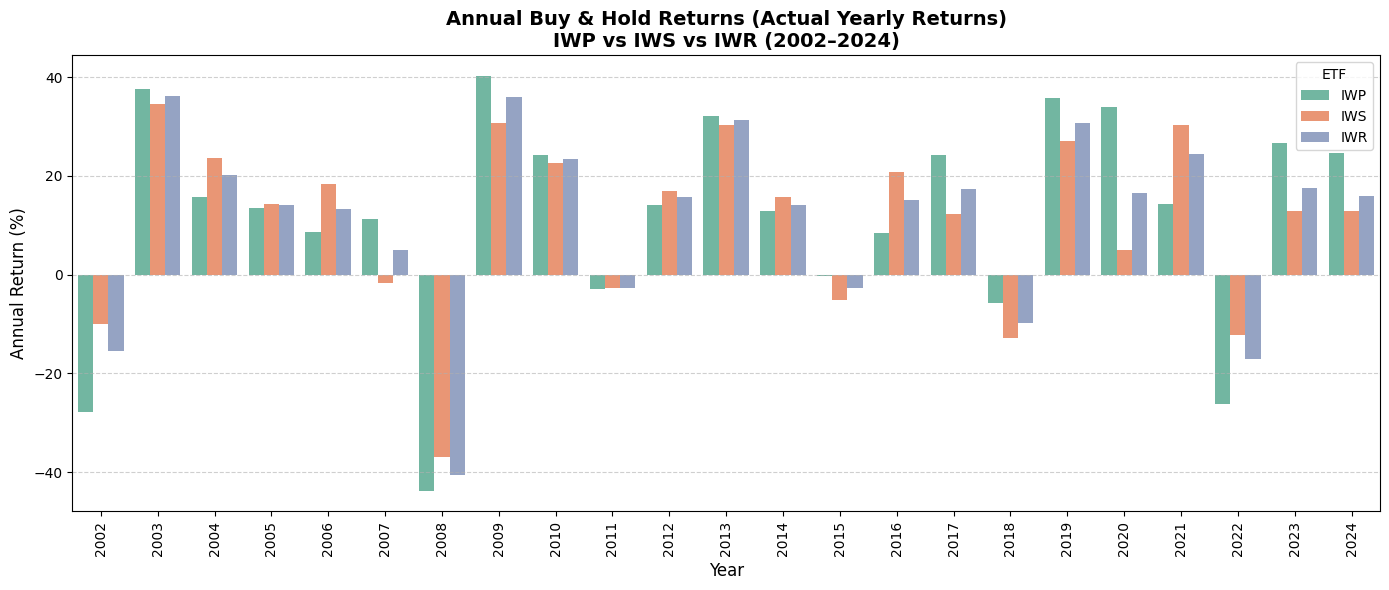

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Load your Buy & Hold annual dataset ----
df = pd.read_csv("/content/buy_and_hold_yearly/IWP_IWS_IWR_buy_and_hold_yearly_2002_2024.csv")

# ---- Ensure correct types ----
df["Year"] = df["Year"].astype(int)
df["AnnualReturn"] = pd.to_numeric(df["AnnualReturn"], errors="coerce")

# ---- Plot Annual Returns as BAR GRAPH ----
plt.figure(figsize=(14, 6))
sns.barplot(
    data=df,
    x="Year",
    y="AnnualReturn",
    hue="Ticker",
    palette="Set2"
)

plt.title("Annual Buy & Hold Returns (Actual Yearly Returns)\nIWP vs IWS vs IWR (2002–2024)",
          fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Annual Return (%)", fontsize=12)
plt.legend(title="ETF")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()




# Semiannual

In [34]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("/content")   # change if your files are elsewhere
OUT_DIR = DATA_DIR / "buy_hold_semiannual_yearwise"
OUT_DIR.mkdir(exist_ok=True, parents=True)

TICKERS = ["IWP", "IWS", "IWR"]
START_CAP = 100.0

def load_clean_generic(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Case: Yahoo UI export with two header rows in first column ("Ticker","Date")
    if "Price" in df.columns and "Adj Close" in df.columns:
        if len(df) > 2 and str(df["Price"].iloc[0]).lower() == "ticker" and str(df["Price"].iloc[1]).lower() == "date":
            df = df.iloc[2:].copy()
            df.rename(columns={"Price": "Date"}, inplace=True)
            df["Date"] = pd.to_datetime(df["Date"])
            for c in ["Adj Close","Close","High","Low","Open","Volume"]:
                if c in df.columns:
                    df[c] = pd.to_numeric(df[c], errors="coerce")
            return df[["Date","Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)
    # Case: standard yfinance CSV
    if "Date" in df.columns and "Adj Close" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        return df[["Date","Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)
    # Case: Date as index
    df2 = pd.read_csv(path, index_col=0)
    df2.index = pd.to_datetime(df2.index)
    if "Adj Close" in df2.columns:
        out = df2[["Adj Close"]].reset_index().rename(columns={"index":"Date"})
        return out[["Date","Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)
    raise ValueError(f"Unrecognized CSV format: {path}")

def semiannual_yearwise(df: pd.DataFrame) -> pd.DataFrame:
    """Return one row per YEAR with H1/H2 returns and year return from halves.
       Also compute cumulative wealth from 10k compounding through halves."""
    d = df.copy()
    d["Year"] = d["Date"].dt.year
    d["Half"] = (d["Date"].dt.month <= 6).astype(int).replace({1:1, 0:2})  # 1 for Jan–Jun, 2 for Jul–Dec

    # first/last price per (Year, Half)
    g_first = d.groupby(["Year","Half"]).first().rename(columns={"Adj Close":"AdjFirst","Date":"FirstDate"})
    g_last  = d.groupby(["Year","Half"]).last().rename(columns={"Adj Close":"AdjLast", "Date":"LastDate"})
    halves = g_first[["FirstDate","AdjFirst"]].join(g_last[["LastDate","AdjLast"]]).dropna().reset_index()

    halves["HalfReturn"] = halves["AdjLast"]/halves["AdjFirst"] - 1.0

    # Pivot: H1/H2 returns, dates, etc. -> one row per Year
    ret_piv = halves.pivot(index="Year", columns="Half", values="HalfReturn").rename(columns={1:"H1_Return",2:"H2_Return"})
    # full-year return from halves
    ret_piv["Year_Return_from_halves"] = (1 + ret_piv["H1_Return"]) * (1 + ret_piv["H2_Return"]) - 1

    # Wealth path: compound across halves in chronological order
    halves = halves.sort_values(["Year","Half"])
    wealth = START_CAP
    wealth_by_half = []
    for _, row in halves.iterrows():
        wealth *= (1 + row["HalfReturn"])
        wealth_by_half.append(wealth)
    halves["Wealth_after_half"] = wealth_by_half

    # Take year-end wealth as wealth after H2 for that year
    year_end_wealth = halves[halves["Half"]==2][["Year","Wealth_after_half"]].set_index("Year").rename(columns={"Wealth_after_half":"YearEnd_CumWealth_from_10k"})

    # Optional: keep first/last dates of H1/H2 for reference
    dates_piv_first = halves.pivot(index="Year", columns="Half", values="FirstDate").rename(columns={1:"H1_FirstDate",2:"H2_FirstDate"})
    dates_piv_last  = halves.pivot(index="Year", columns="Half", values="LastDate").rename(columns={1:"H1_LastDate", 2:"H2_LastDate"})

    out = ret_piv.join(year_end_wealth).join(dates_piv_first).join(dates_piv_last).reset_index()

    # Nice formatting (keep numerical precision reasonable)
    for c in ["H1_Return","H2_Return","Year_Return_from_halves"]:
        out[c] = (out[c]*100).round(2)   # percent
    out["YearEnd_CumWealth_from_10k"] = out["YearEnd_CumWealth_from_10k"].round(2)
    return out

# ---- Run for all tickers ----
combined = []
for t in TICKERS:
    df = load_clean_generic(DATA_DIR / f"{t}_2002_2024.csv")
    res = semiannual_yearwise(df)
    res.insert(1, "Ticker", t)
    res.to_csv(OUT_DIR / f"{t}_semiannual_yearwise_2002_2024.csv", index=False)
    combined.append(res)

combined_df = pd.concat(combined, ignore_index=True)
combined_df.to_csv(OUT_DIR / "IWP_IWS_IWR_semiannual_yearwise_2002_2024.csv", index=False)

print("✅ Saved:")
print(f"- {OUT_DIR/'IWP_semiannual_yearwise_2002_2024.csv'}")
print(f"- {OUT_DIR/'IWS_semiannual_yearwise_2002_2024.csv'}")
print(f"- {OUT_DIR/'IWR_semiannual_yearwise_2002_2024.csv'}")
print(f"- {OUT_DIR/'IWP_IWS_IWR_semiannual_yearwise_2002_2024.csv'} (combined)")
print("\nPreview:")
print(combined_df.head(8))


✅ Saved:
- /content/buy_hold_semiannual_yearwise/IWP_semiannual_yearwise_2002_2024.csv
- /content/buy_hold_semiannual_yearwise/IWS_semiannual_yearwise_2002_2024.csv
- /content/buy_hold_semiannual_yearwise/IWR_semiannual_yearwise_2002_2024.csv
- /content/buy_hold_semiannual_yearwise/IWP_IWS_IWR_semiannual_yearwise_2002_2024.csv (combined)

Preview:
   Year Ticker  H1_Return  H2_Return  Year_Return_from_halves  \
0  2002    IWP     -20.15      -6.64                   -25.45   
1  2003    IWP      14.94      19.08                    36.87   
2  2004    IWP       6.61      10.33                    17.62   
3  2005    IWP       3.19       9.59                    13.08   
4  2006    IWP       0.82       7.26                     8.14   
5  2007    IWP      10.87      -0.84                     9.93   
6  2008    IWP      -5.66     -40.50                   -43.87   
7  2009    IWP      11.88      24.70                    39.52   

   YearEnd_CumWealth_from_10k H1_FirstDate H2_FirstDate H1_LastD

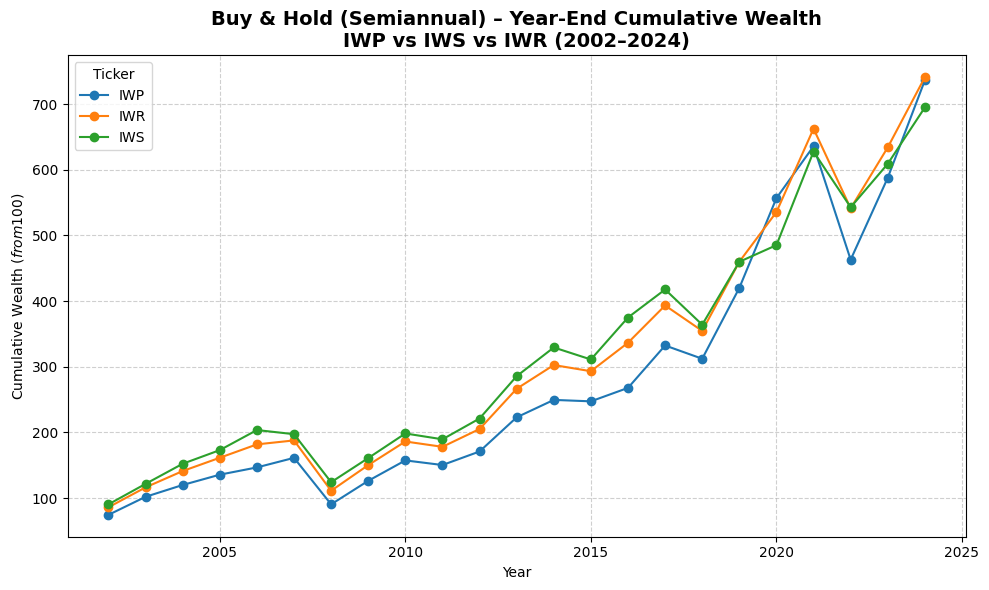

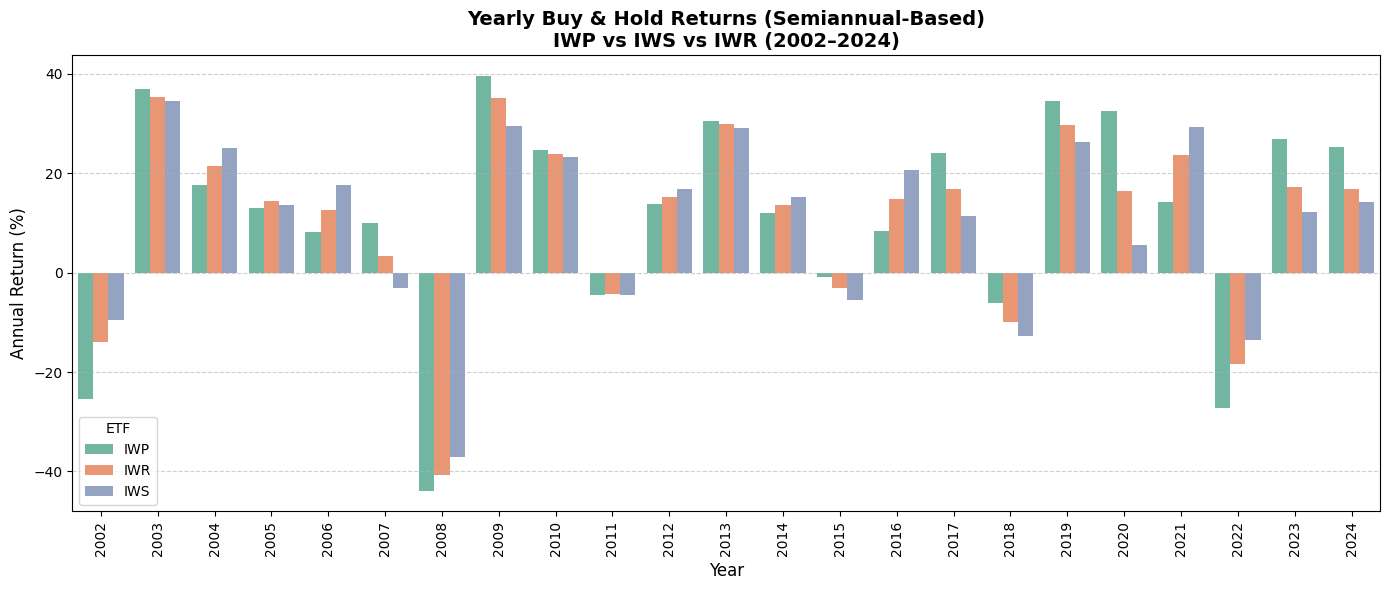

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Load the combined semiannual year-wise results
df = pd.read_csv("/content/buy_hold_semiannual_yearwise/IWP_IWS_IWR_semiannual_yearwise_2002_2024.csv")

# Ensure numeric and sorted
df["Year"] = df["Year"].astype(int)
df["Year_Return_from_halves"] = pd.to_numeric(df["Year_Return_from_halves"], errors="coerce")
df = df.sort_values(["Ticker", "Year"])

# ---- 1️⃣ Plot Year-End Cumulative Wealth (Line Chart) ----
plt.figure(figsize=(10,6))
for t in df["Ticker"].unique():
    d = df[df["Ticker"] == t]
    plt.plot(d["Year"], d["YearEnd_CumWealth_from_10k"], marker="o", label=t)

plt.title("Buy & Hold (Semiannual) – Year-End Cumulative Wealth\nIWP vs IWS vs IWR (2002–2024)", fontsize=14, fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Cumulative Wealth ($ from $100)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Ticker")
plt.tight_layout()
plt.show()


# ---- 2️⃣ Plot Full-Year Return (Semiannual-Based) as BAR GRAPH (Seaborn) ----
plt.figure(figsize=(14, 6))
sns.barplot(
    data=df,
    x="Year",
    y="Year_Return_from_halves",
    hue="Ticker",
    palette="Set2"
)

plt.title("Yearly Buy & Hold Returns (Semiannual-Based)\nIWP vs IWS vs IWR (2002–2024)", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Annual Return (%)", fontsize=12)
plt.legend(title="ETF")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


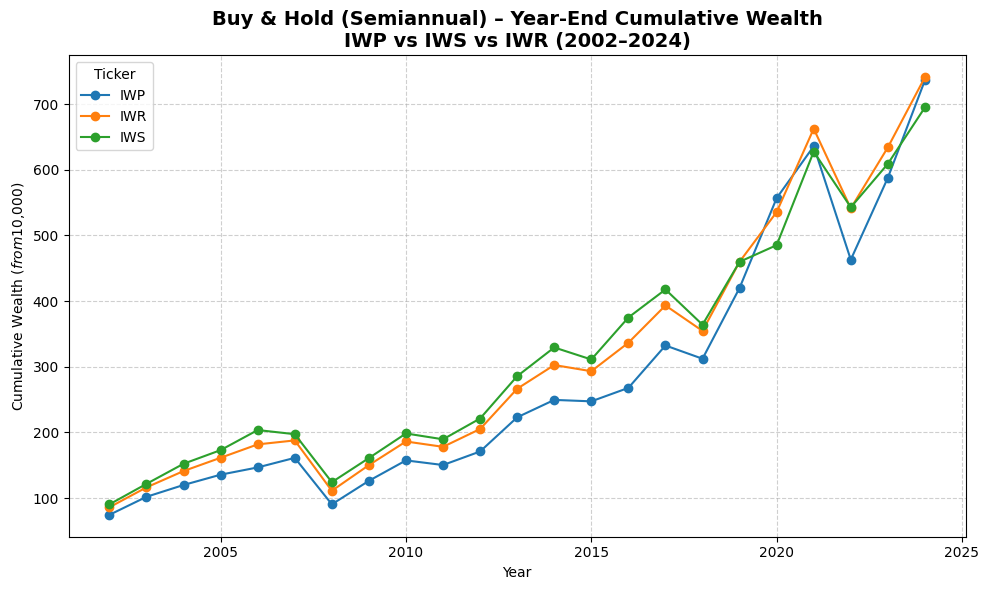

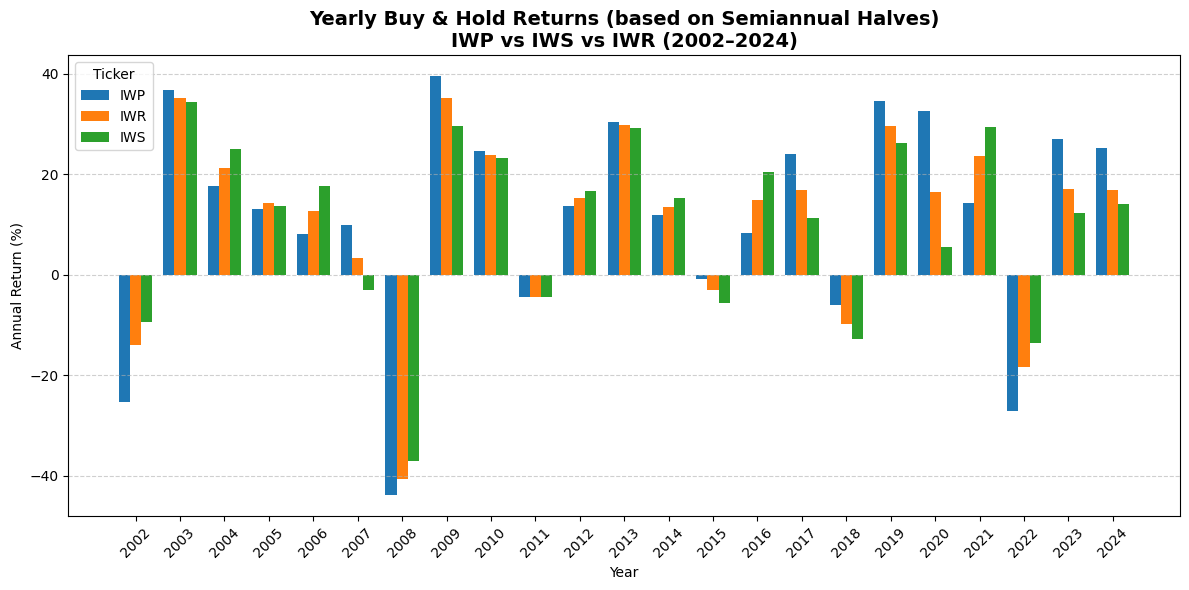

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Load the combined semiannual year-wise results
df = pd.read_csv("/content/buy_hold_semiannual_yearwise/IWP_IWS_IWR_semiannual_yearwise_2002_2024.csv")

# Ensure numeric and sorted
df["Year"] = df["Year"].astype(int)
df = df.sort_values(["Ticker", "Year"])

# ---- 1️⃣ Plot Year-End Cumulative Wealth ----
plt.figure(figsize=(10,6))
for t in df["Ticker"].unique():
    d = df[df["Ticker"] == t]
    plt.plot(d["Year"], d["YearEnd_CumWealth_from_10k"], marker="o", label=t)

plt.title("Buy & Hold (Semiannual) – Year-End Cumulative Wealth\nIWP vs IWS vs IWR (2002–2024)", fontsize=14, fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Cumulative Wealth ($ from $10,000)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Ticker")
plt.tight_layout()
plt.show()


# ---- 2️⃣ Plot Full-Year Return (as Grouped Bar Chart) ----
plt.figure(figsize=(12,6))

tickers = df["Ticker"].unique()
years = sorted(df["Year"].unique())
bar_width = 0.25

x = np.arange(len(years))

for i, t in enumerate(tickers):
    d = df[df["Ticker"] == t]
    plt.bar(x + i * bar_width,
            d["Year_Return_from_halves"],
            width=bar_width,
            label=t)

plt.title("Yearly Buy & Hold Returns (based on Semiannual Halves)\nIWP vs IWS vs IWR (2002–2024)", fontsize=14, fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Annual Return (%)")
plt.xticks(x + bar_width, years, rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Ticker")
plt.tight_layout()
plt.show()


# Quaterly

In [37]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("/content")  # folder where your CSVs (IWP, IWS, IWR) are stored
OUT_DIR = DATA_DIR / "buy_hold_quarterly_yearwise"
OUT_DIR.mkdir(exist_ok=True, parents=True)

TICKERS = ["IWP", "IWS", "IWR"]
START_CAP = 100.0

def load_clean_generic(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "Price" in df.columns and "Adj Close" in df.columns:
        if len(df) > 2 and str(df["Price"].iloc[0]).lower() == "ticker" and str(df["Price"].iloc[1]).lower() == "date":
            df = df.iloc[2:].copy()
            df.rename(columns={"Price": "Date"}, inplace=True)
            df["Date"] = pd.to_datetime(df["Date"])
            for c in ["Adj Close","Close","High","Low","Open","Volume"]:
                if c in df.columns:
                    df[c] = pd.to_numeric(df[c], errors="coerce")
            return df[["Date","Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)
    if "Date" in df.columns and "Adj Close" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        return df[["Date","Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)
    df2 = pd.read_csv(path, index_col=0)
    df2.index = pd.to_datetime(df2.index)
    if "Adj Close" in df2.columns:
        out = df2[["Adj Close"]].reset_index().rename(columns={"index":"Date"})
        return out[["Date","Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)
    raise ValueError(f"Unrecognized format: {path}")

def quarterly_yearwise(df: pd.DataFrame) -> pd.DataFrame:
    """Compute Q1–Q4 buy & hold per year, plus yearly return and cumulative wealth."""
    d = df.copy()
    d["Year"] = d["Date"].dt.year
    d["Quarter"] = d["Date"].dt.quarter

    g_first = d.groupby(["Year","Quarter"]).first().rename(columns={"Adj Close":"AdjFirst","Date":"FirstDate"})
    g_last  = d.groupby(["Year","Quarter"]).last().rename(columns={"Adj Close":"AdjLast","Date":"LastDate"})
    qtrs = g_first[["FirstDate","AdjFirst"]].join(g_last[["LastDate","AdjLast"]]).dropna().reset_index()

    qtrs["QtrReturn"] = qtrs["AdjLast"]/qtrs["AdjFirst"] - 1.0

    # pivot to one row per year with Q1–Q4 returns
    ret_piv = qtrs.pivot(index="Year", columns="Quarter", values="QtrReturn").rename(
        columns={1:"Q1_Return",2:"Q2_Return",3:"Q3_Return",4:"Q4_Return"}
    )
    ret_piv["Year_Return_from_quarters"] = (
        (1+ret_piv["Q1_Return"]) *
        (1+ret_piv["Q2_Return"]) *
        (1+ret_piv["Q3_Return"]) *
        (1+ret_piv["Q4_Return"]) - 1
    )

    # wealth path compounding each quarter
    qtrs = qtrs.sort_values(["Year","Quarter"])
    wealth = START_CAP
    wealth_list = []
    for _, row in qtrs.iterrows():
        wealth *= (1 + row["QtrReturn"])
        wealth_list.append(wealth)
    qtrs["Wealth_after_quarter"] = wealth_list

    # year-end cumulative wealth = wealth after Q4
    year_end_wealth = qtrs[qtrs["Quarter"]==4][["Year","Wealth_after_quarter"]] \
        .set_index("Year").rename(columns={"Wealth_after_quarter":"YearEnd_CumWealth_from_10k"})

    out = ret_piv.join(year_end_wealth).reset_index()
    for c in ["Q1_Return","Q2_Return","Q3_Return","Q4_Return","Year_Return_from_quarters"]:
        out[c] = (out[c]*100).round(2)
    out["YearEnd_CumWealth_from_10k"] = out["YearEnd_CumWealth_from_10k"].round(2)
    return out

# ---- Run for all tickers ----
combined = []
for t in TICKERS:
    df = load_clean_generic(DATA_DIR / f"{t}_2002_2024.csv")
    res = quarterly_yearwise(df)
    res.insert(1, "Ticker", t)
    res.to_csv(OUT_DIR / f"{t}_quarterly_yearwise_2002_2024.csv", index=False)
    combined.append(res)

combined_df = pd.concat(combined, ignore_index=True)
combined_df.to_csv(OUT_DIR / "IWP_IWS_IWR_quarterly_yearwise_2002_2024.csv", index=False)

print("✅ Saved quarterly year-wise files in:", OUT_DIR)
print(combined_df.head(8))


✅ Saved quarterly year-wise files in: /content/buy_hold_quarterly_yearwise
   Year Ticker  Q1_Return  Q2_Return  Q3_Return  Q4_Return  \
0  2002    IWP      -1.59     -18.72     -14.04       8.50   
1  2003    IWP      -2.83      19.09       6.24      10.34   
2  2004    IWP       5.46       0.47      -2.56      11.95   
3  2005    IWP      -0.18       3.71       6.14       2.63   
4  2006    IWP       6.19      -4.66       0.36       7.29   
5  2007    IWP       4.15       6.25       0.84      -2.89   
6  2008    IWP      -9.70       1.06     -17.85     -26.24   
7  2009    IWP      -7.61      19.35      16.64      10.20   

   Year_Return_from_quarters  YearEnd_CumWealth_from_10k  
0                     -25.40                       74.60  
1                      35.65                      101.19  
2                      15.58                      116.96  
3                      12.77                      131.90  
4                       9.02                      143.79  
5           

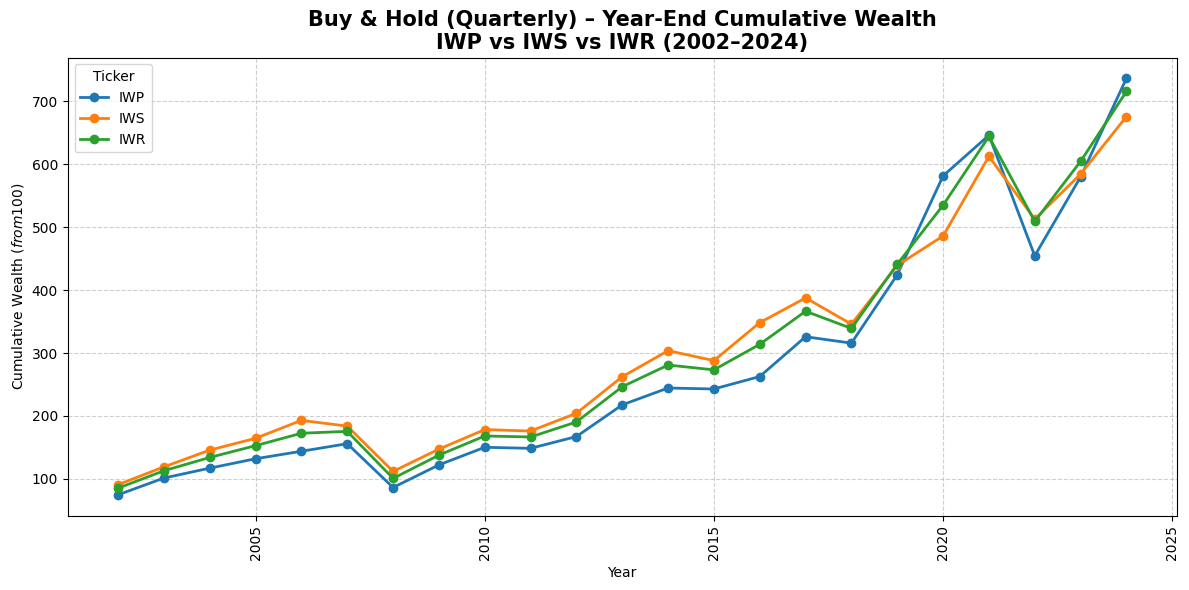

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the combined quarterly year-wise file (if needed)
# df = combined_df  # already available
df = combined_df.copy()

plt.figure(figsize=(12, 6))

for t in df["Ticker"].unique():
    d = df[df["Ticker"] == t]
    plt.plot(d["Year"], d["YearEnd_CumWealth_from_10k"],
             marker="o", linewidth=2, label=t)

plt.title("Buy & Hold (Quarterly) – Year-End Cumulative Wealth\nIWP vs IWS vs IWR (2002–2024)",
          fontsize=15, fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Cumulative Wealth ($ from $100)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Ticker")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


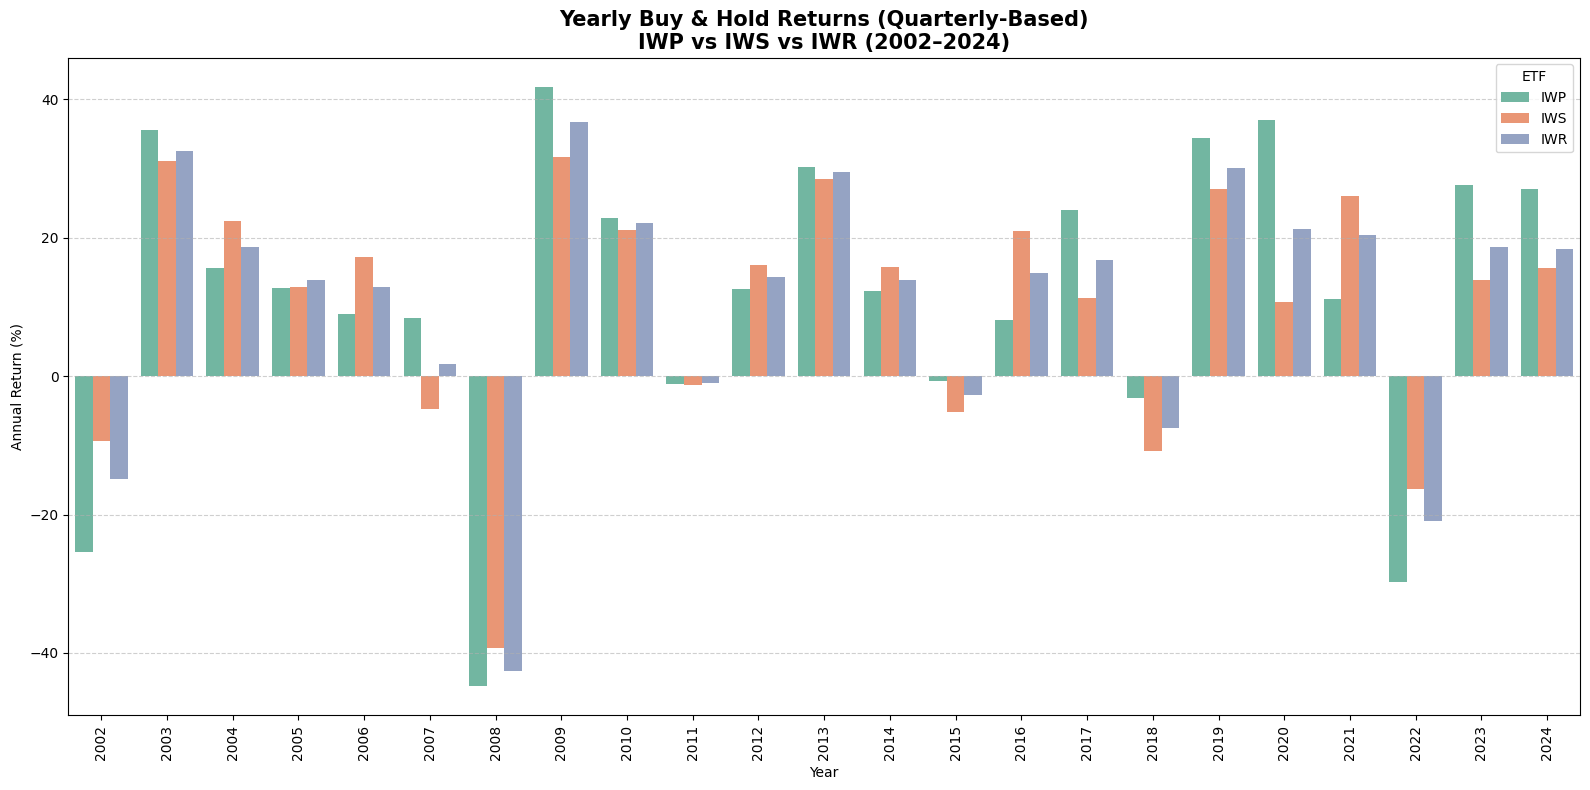

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))  # Bigger chart

sns.barplot(
    data=df,
    x="Year",
    y="Year_Return_from_quarters",
    hue="Ticker",
    palette="Set2",
    errorbar=None  # removes error bars
)

plt.title("Yearly Buy & Hold Returns (Quarterly-Based)\nIWP vs IWS vs IWR (2002–2024)",
          fontsize=15, fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Annual Return (%)")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="ETF")
plt.tight_layout()
plt.show()



# Monthly

In [40]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("/content")   # Folder with your IWP_2002_2024.csv etc.
OUT_DIR = DATA_DIR / "buy_hold_monthly_yearwise"
OUT_DIR.mkdir(exist_ok=True, parents=True)

TICKERS = ["IWP", "IWS", "IWR"]
START_CAP = 100.0

def load_clean_generic(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "Price" in df.columns and "Adj Close" in df.columns:
        if len(df) > 2 and str(df["Price"].iloc[0]).lower() == "ticker" and str(df["Price"].iloc[1]).lower() == "date":
            df = df.iloc[2:].copy()
            df.rename(columns={"Price": "Date"}, inplace=True)
            df["Date"] = pd.to_datetime(df["Date"])
            for c in ["Adj Close","Close","High","Low","Open","Volume"]:
                if c in df.columns:
                    df[c] = pd.to_numeric(df[c], errors="coerce")
            return df[["Date","Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)
    if "Date" in df.columns and "Adj Close" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        return df[["Date","Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)
    df2 = pd.read_csv(path, index_col=0)
    df2.index = pd.to_datetime(df2.index)
    if "Adj Close" in df2.columns:
        out = df2[["Adj Close"]].reset_index().rename(columns={"index":"Date"})
        return out[["Date","Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)
    raise ValueError(f"Unrecognized format for {path}")

def monthly_yearwise(df: pd.DataFrame) -> pd.DataFrame:
    """Compute monthly buy & hold per year, plus year return and cumulative wealth."""
    d = df.copy()
    d["Year"] = d["Date"].dt.year
    d["Month"] = d["Date"].dt.month

    # first & last trading day per month
    g_first = d.groupby(["Year","Month"]).first().rename(columns={"Adj Close":"AdjFirst","Date":"FirstDate"})
    g_last  = d.groupby(["Year","Month"]).last().rename(columns={"Adj Close":"AdjLast","Date":"LastDate"})
    months = g_first[["FirstDate","AdjFirst"]].join(g_last[["LastDate","AdjLast"]]).dropna().reset_index()

    months["MonthReturn"] = months["AdjLast"]/months["AdjFirst"] - 1.0

    # pivot to one row per year with M1–M12
    ret_piv = months.pivot(index="Year", columns="Month", values="MonthReturn")
    ret_piv.columns = [f"M{m}_Return" for m in ret_piv.columns]

    # yearly return from all available months
    ret_piv["Year_Return_from_months"] = (ret_piv.add(1).prod(axis=1) - 1)

    # wealth compounding monthly
    months = months.sort_values(["Year","Month"])
    wealth = START_CAP
    wealth_list = []
    for _, row in months.iterrows():
        wealth *= (1 + row["MonthReturn"])
        wealth_list.append(wealth)
    months["Wealth_after_month"] = wealth_list

    # pick last month of each year
    year_end_wealth = months.groupby("Year").last()[["Wealth_after_month"]] \
        .rename(columns={"Wealth_after_month":"YearEnd_CumWealth_from_10k"})

    out = ret_piv.join(year_end_wealth).reset_index()

    # format %
    for c in out.columns:
        if "Return" in c:
            out[c] = (out[c]*100).round(2)
    out["YearEnd_CumWealth_from_10k"] = out["YearEnd_CumWealth_from_10k"].round(2)
    return out

# ---- Run for all tickers ----
combined = []
for t in TICKERS:
    df = load_clean_generic(DATA_DIR / f"{t}_2002_2024.csv")
    res = monthly_yearwise(df)
    res.insert(1, "Ticker", t)
    res.to_csv(OUT_DIR / f"{t}_monthly_yearwise_2002_2024.csv", index=False)
    combined.append(res)

combined_df = pd.concat(combined, ignore_index=True)
combined_df.to_csv(OUT_DIR / "IWP_IWS_IWR_monthly_yearwise_2002_2024.csv", index=False)

print("✅ Saved monthly year-wise files in:", OUT_DIR)
print(combined_df.head(10))


✅ Saved monthly year-wise files in: /content/buy_hold_monthly_yearwise
   Year Ticker  M1_Return  M2_Return  M3_Return  M4_Return  M5_Return  \
0  2002    IWP      -3.46      -4.66       4.71      -5.53      -3.50   
1  2003    IWP      -4.23      -1.44       3.43       7.09       9.13   
2  2004    IWP       3.77       1.87      -1.60      -3.45       1.24   
3  2005    IWP      -1.09       1.86      -2.22      -3.74       5.14   
4  2006    IWP       3.98      -1.32       1.79       0.41      -4.53   
5  2007    IWP       3.47      -0.97       1.15       4.01       3.84   
6  2008    IWP      -6.76      -3.61      -1.90       3.60       3.86   
7  2009    IWP      -8.48      -7.23      15.43      12.84       4.71   
8  2010    IWP      -5.33       3.14       4.50       2.12      -8.30   
9  2011    IWP       0.79       2.55       3.58       2.92       0.02   

   M6_Return  M7_Return  M8_Return  M9_Return  M10_Return  M11_Return  \
0      -8.87      -6.64       4.20      -4.08       

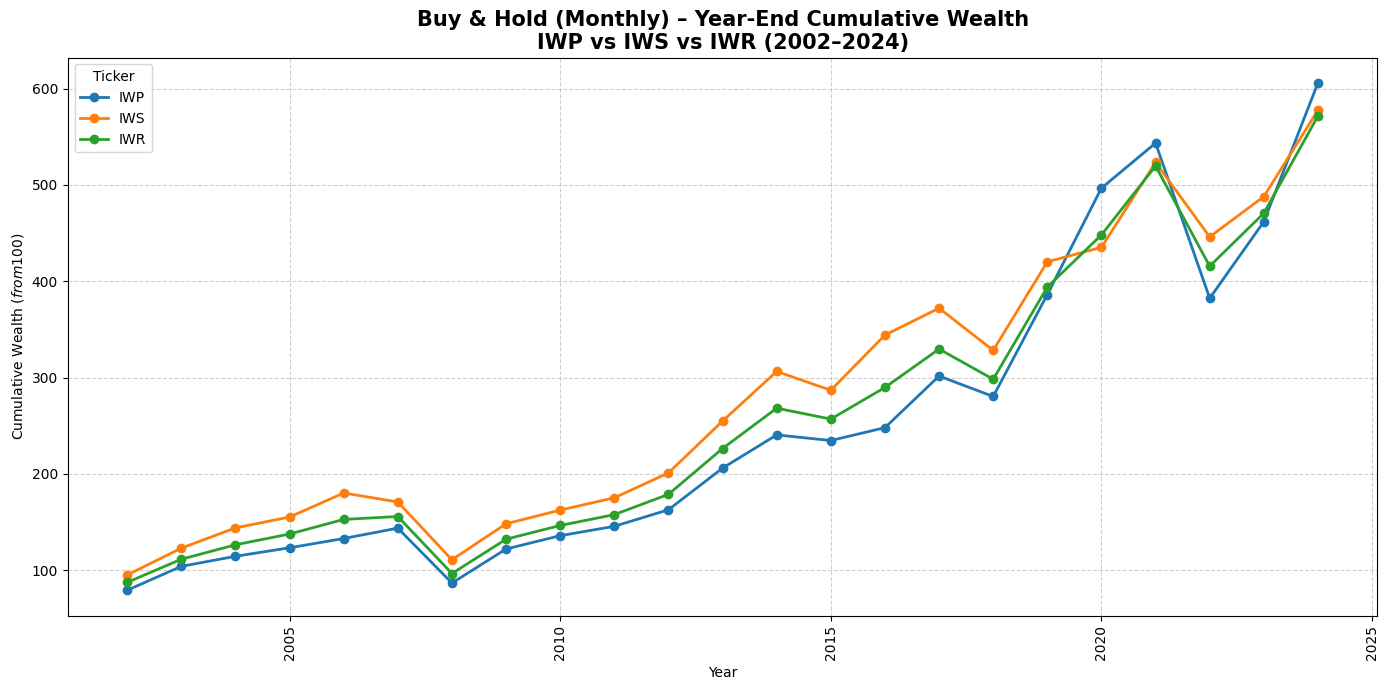

In [41]:
import matplotlib.pyplot as plt

df = combined_df.copy()

plt.figure(figsize=(14, 7))

for t in df["Ticker"].unique():
    d = df[df["Ticker"] == t]
    plt.plot(
        d["Year"],
        d["YearEnd_CumWealth_from_10k"],
        marker="o",
        linewidth=2,
        label=t
    )

plt.title("Buy & Hold (Monthly) – Year-End Cumulative Wealth\nIWP vs IWS vs IWR (2002–2024)",
          fontsize=15, fontweight="bold")

plt.xlabel("Year")
plt.ylabel("Cumulative Wealth ($ from $100)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Ticker")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


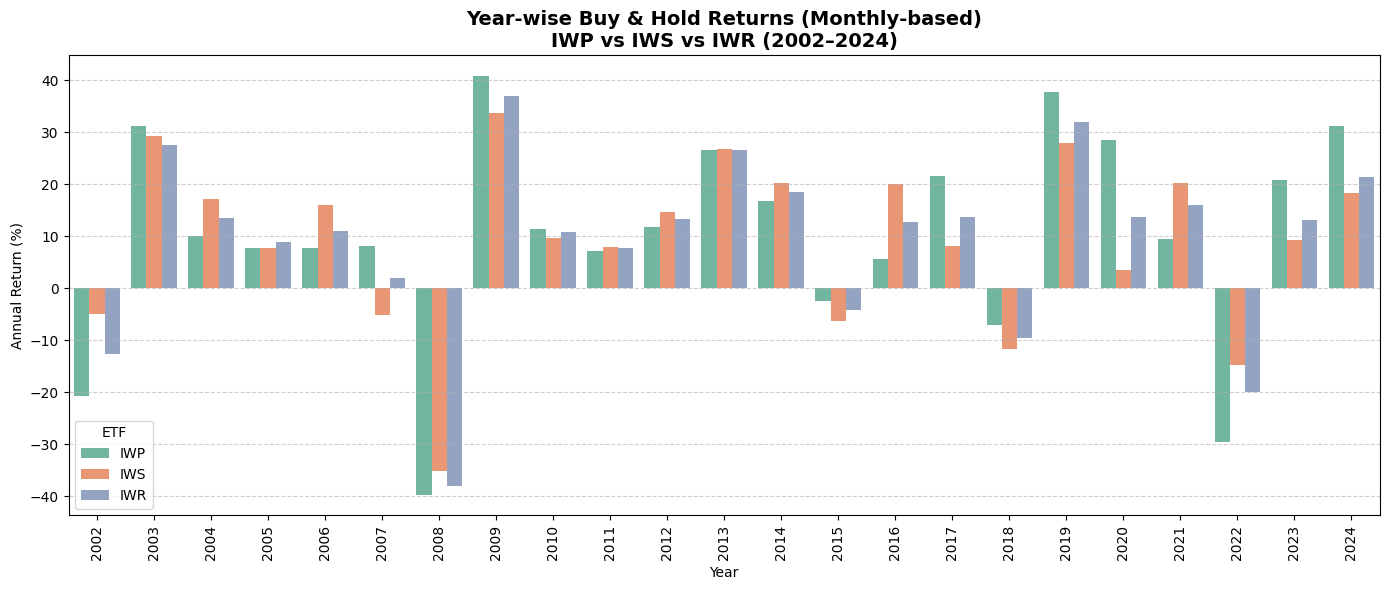

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/buy_hold_monthly_yearwise/IWP_IWS_IWR_monthly_yearwise_2002_2024.csv")
df["Year"] = df["Year"].astype(int)

plt.figure(figsize=(14,6))
sns.barplot(data=df, x="Year", y="Year_Return_from_months", hue="Ticker", palette="Set2")

plt.title("Year-wise Buy & Hold Returns (Monthly-based)\nIWP vs IWS vs IWR (2002–2024)", fontsize=14, fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Annual Return (%)")
plt.legend(title="ETF")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Weekly

In [43]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("/content")   # change if your files live elsewhere
OUT_DIR = DATA_DIR / "buy_hold_weekly_yearwise"
OUT_DIR.mkdir(exist_ok=True, parents=True)

TICKERS = ["IWP", "IWS", "IWR"]
START_CAP = 100.0

def load_clean_generic(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Missing CSV: {path}")
    df = pd.read_csv(path)

    # Case 1: Yahoo-UI style where first col 'Price' has 'Ticker', 'Date' rows
    if "Price" in df.columns and "Adj Close" in df.columns and len(df) > 2:
        if str(df["Price"].iloc[0]).strip().lower() == "ticker" and str(df["Price"].iloc[1]).strip().lower() == "date":
            df = df.iloc[2:].copy()                       # drop the two header rows
            df = df.rename(columns={"Price": "Date"})
            df["Date"] = pd.to_datetime(df["Date"])
            for c in ["Adj Close","Close","High","Low","Open","Volume"]:
                if c in df.columns:
                    df[c] = pd.to_numeric(df[c], errors="coerce")
            return df[["Date","Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)

    # Case 2: standard yfinance CSV with 'Date' column
    if "Date" in df.columns and "Adj Close" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        return df[["Date","Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)

    # Case 3: Date as index
    df2 = pd.read_csv(path, index_col=0)
    try:
        df2.index = pd.to_datetime(df2.index)
    except Exception:
        pass
    if "Adj Close" in df2.columns:
        out = df2[["Adj Close"]].reset_index().rename(columns={"index":"Date"})
        out["Date"] = pd.to_datetime(out["Date"])
        return out[["Date","Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)

    raise ValueError(f"Unrecognized CSV structure: {path}")

def weekly_yearwise(df: pd.DataFrame) -> pd.DataFrame:
    """Weekly buy @ first trading day of week, sell @ last; aggregate by calendar year."""
    d = df.copy()
    d["Year"] = d["Date"].dt.year
    # ISO week number; cast to plain int to avoid dtype issues
    d["Week"] = d["Date"].dt.isocalendar().week.astype(int)

    # If an ISO week 1 falls in late December, attribute it to next calendar year
    d.loc[(d["Date"].dt.month == 12) & (d["Week"] == 1), "Year"] += 1

    # First/last within (Year, Week)
    g_first = d.groupby(["Year","Week"]).first().rename(columns={"Adj Close":"AdjFirst","Date":"FirstDate"})
    g_last  = d.groupby(["Year","Week"]).last().rename(columns={"Adj Close":"AdjLast","Date":"LastDate"})
    weeks = g_first[["FirstDate","AdjFirst"]].join(g_last[["LastDate","AdjLast"]]).dropna().reset_index()

    if weeks.empty:
        raise RuntimeError("No weekly groups formed. Check your input dates/columns.")

    weeks["WeekReturn"] = weeks["AdjLast"] / weeks["AdjFirst"] - 1.0

    # Yearly compounded return from all weeks in that year
    yearly = weeks.groupby("Year")["WeekReturn"].apply(lambda x: (1 + x).prod() - 1).to_frame("Year_Return_from_weeks")

    # Wealth compounding week-to-week from START_CAP
    weeks = weeks.sort_values(["Year","Week"])
    wealth = START_CAP
    vals = []
    for r in weeks["WeekReturn"]:
        wealth *= (1 + r)
        vals.append(wealth)
    weeks["Wealth_after_week"] = vals

    # Year-end wealth = after last week of that year
    year_end = weeks.groupby("Year").last()[["Wealth_after_week"]].rename(
        columns={"Wealth_after_week":"YearEnd_CumWealth_from_10k"}
    )

    out = yearly.join(year_end).reset_index()
    out["Year_Return_from_weeks"] = (out["Year_Return_from_weeks"] * 100).round(2)
    out["YearEnd_CumWealth_from_10k"] = out["YearEnd_CumWealth_from_10k"].round(2)
    return out

# -------- run for all tickers --------
combined = []
for t in TICKERS:
    src = DATA_DIR / f"{t}_2002_2024.csv"
    df = load_clean_generic(src)
    res = weekly_yearwise(df)
    res.insert(1, "Ticker", t)
    # save per-ticker
    out_file = OUT_DIR / f"{t}_weekly_yearwise_2002_2024.csv"
    res.to_csv(out_file, index=False)
    print(f"Saved: {out_file}")
    combined.append(res)

# combined file
combined_df = pd.concat(combined, ignore_index=True)
combined_path = OUT_DIR / "IWP_IWS_IWR_weekly_yearwise_2002_2024.csv"
combined_df.to_csv(combined_path, index=False)

print("\n✅ All good!")
print(f"Combined file: {combined_path}")
print(combined_df.head(10))


Saved: /content/buy_hold_weekly_yearwise/IWP_weekly_yearwise_2002_2024.csv
Saved: /content/buy_hold_weekly_yearwise/IWS_weekly_yearwise_2002_2024.csv
Saved: /content/buy_hold_weekly_yearwise/IWR_weekly_yearwise_2002_2024.csv

✅ All good!
Combined file: /content/buy_hold_weekly_yearwise/IWP_IWS_IWR_weekly_yearwise_2002_2024.csv
   Year Ticker  Year_Return_from_weeks  YearEnd_CumWealth_from_10k
0  2002    IWP                   -8.47                       91.53
1  2003    IWP                   26.98                      116.23
2  2004    IWP                   16.99                      135.97
3  2005    IWP                    4.40                      141.96
4  2006    IWP                   14.57                      162.64
5  2007    IWP                   16.73                      189.86
6  2008    IWP                  -36.61                      120.36
7  2009    IWP                   65.26                      198.90
8  2010    IWP                    8.78                      216.37
9

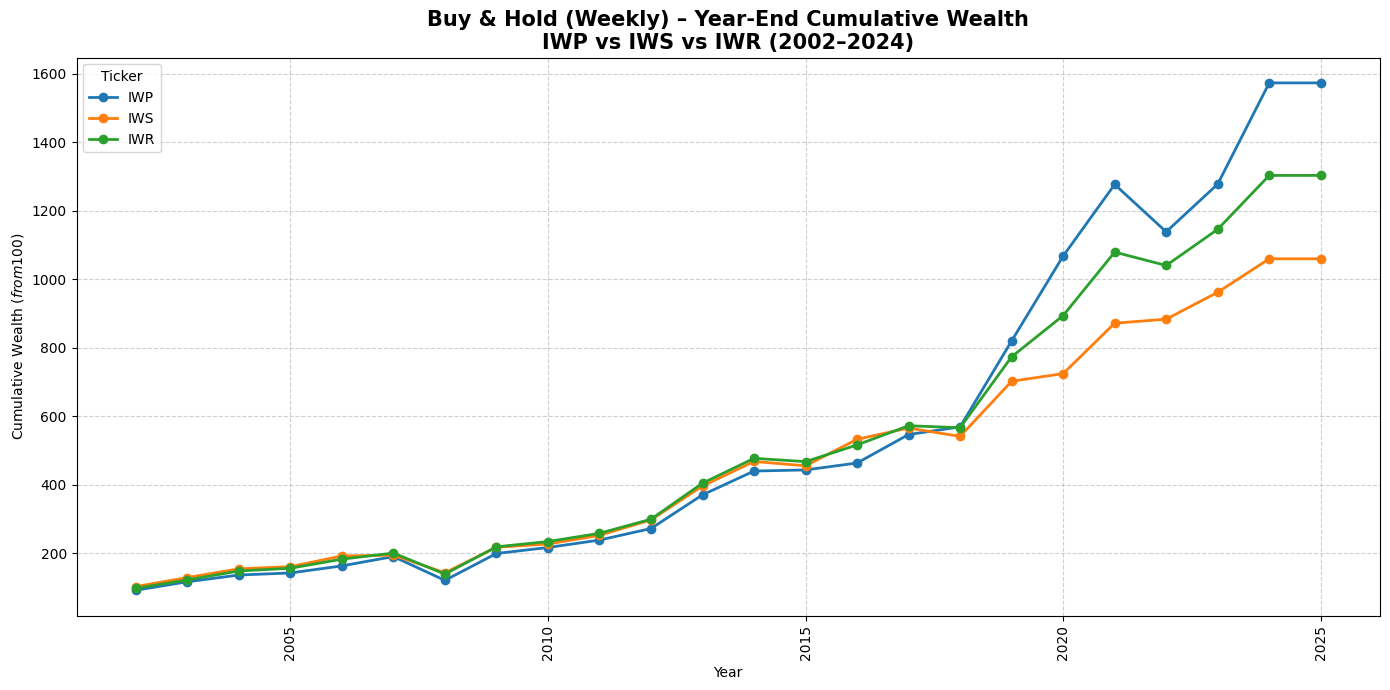

In [44]:
import matplotlib.pyplot as plt

df = combined_df.copy()

plt.figure(figsize=(14, 7))

for t in df["Ticker"].unique():
    d = df[df["Ticker"] == t]
    plt.plot(
        d["Year"],
        d["YearEnd_CumWealth_from_10k"],
        marker="o",
        linewidth=2,
        label=t
    )

plt.title("Buy & Hold (Weekly) – Year-End Cumulative Wealth\nIWP vs IWS vs IWR (2002–2024)",
          fontsize=15, fontweight="bold")

plt.xlabel("Year")
plt.ylabel("Cumulative Wealth ($ from $100)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Ticker")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


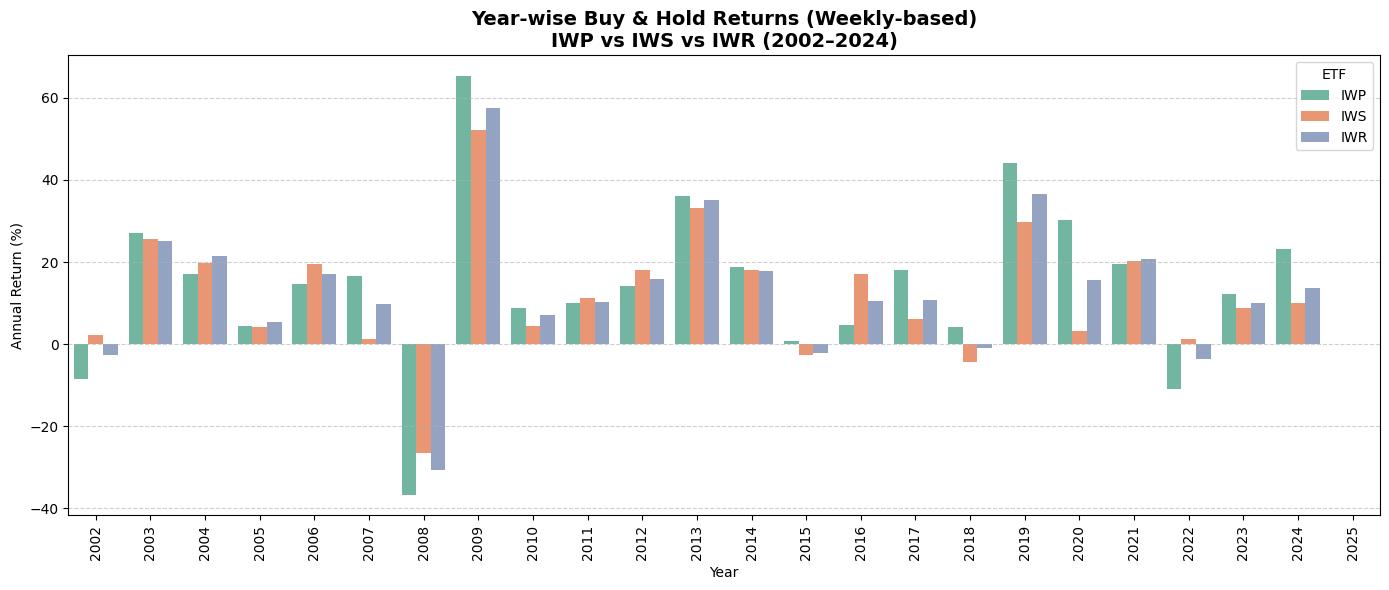

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# make sure this path matches where your code saved the files
combined_path = Path("/content/buy_hold_weekly_yearwise/IWP_IWS_IWR_weekly_yearwise_2002_2024.csv")

if not combined_path.exists():
    print("❌ Combined file not found.  Run the weekly_buy_hold script first or check your folder name.")
else:
    df = pd.read_csv(combined_path)
    df["Year"] = df["Year"].astype(int)

    plt.figure(figsize=(14,6))
    sns.barplot(data=df, x="Year", y="Year_Return_from_weeks", hue="Ticker", palette="Set2")

    plt.title("Year-wise Buy & Hold Returns (Weekly-based)\nIWP vs IWS vs IWR (2002–2024)", fontsize=14, fontweight="bold")
    plt.xlabel("Year")
    plt.ylabel("Annual Return (%)")
    plt.legend(title="ETF")
    plt.xticks(rotation=90)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


# Daily

In [46]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("/content")   # change if your CSVs are elsewhere
OUT_DIR = DATA_DIR / "buy_hold_daily_yearwise"
OUT_DIR.mkdir(exist_ok=True, parents=True)

TICKERS = ["IWP", "IWS", "IWR"]
START_CAP = 100.0

def load_clean_generic(path: Path) -> pd.DataFrame:
    """Load CSV in several common formats and return [Date, Adj Close] sorted."""
    if not path.exists():
        raise FileNotFoundError(f"Missing CSV: {path}")
    df = pd.read_csv(path)

    # Yahoo UI export (first col 'Price' has 'Ticker','Date' rows)
    if "Price" in df.columns and "Adj Close" in df.columns and len(df) > 2:
        if str(df["Price"].iloc[0]).strip().lower() == "ticker" and str(df["Price"].iloc[1]).strip().lower() == "date":
            df = df.iloc[2:].copy()
            df = df.rename(columns={"Price": "Date"})
            df["Date"] = pd.to_datetime(df["Date"])
            for c in ["Adj Close","Close","High","Low","Open","Volume"]:
                if c in df.columns:
                    df[c] = pd.to_numeric(df[c], errors="coerce")
            return df[["Date","Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)

    # Standard yfinance export
    if "Date" in df.columns and "Adj Close" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        return df[["Date","Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)

    # Date as index
    df2 = pd.read_csv(path, index_col=0)
    try:
        df2.index = pd.to_datetime(df2.index)
    except Exception:
        pass
    if "Adj Close" in df2.columns:
        out = df2[["Adj Close"]].reset_index().rename(columns={"index":"Date"})
        out["Date"] = pd.to_datetime(out["Date"])
        return out[["Date","Adj Close"]].dropna().sort_values("Date").reset_index(drop=True)

    raise ValueError(f"Unrecognized CSV structure: {path}")

def daily_yearwise(df: pd.DataFrame) -> pd.DataFrame:
    """Compute year-wise results by compounding daily returns within each year."""
    d = df.copy()
    d = d.sort_values("Date")
    # daily return from Adj Close
    d["DailyRet"] = d["Adj Close"].pct_change().fillna(0.0)

    d["Year"] = d["Date"].dt.year

    # annual compounded return from daily rets in that year
    year_ret = d.groupby("Year")["DailyRet"].apply(lambda x: (1 + x).prod() - 1).to_frame("Year_Return_from_days")

    # cumulative wealth from $10k compounding day-by-day across full series
    wealth = START_CAP
    wealth_series = []
    for r in d["DailyRet"]:
        wealth *= (1 + r)
        wealth_series.append(wealth)
    d["Wealth_after_day"] = wealth_series

    # take last day of each year as year-end wealth
    year_end = d.groupby("Year").last()[["Wealth_after_day"]] \
                .rename(columns={"Wealth_after_day":"YearEnd_CumWealth_from_10k"})

    out = year_ret.join(year_end).reset_index()
    out["Year_Return_from_days"] = (out["Year_Return_from_days"] * 100).round(2)
    out["YearEnd_CumWealth_from_10k"] = out["YearEnd_CumWealth_from_10k"].round(2)
    return out

# ---- Run for all tickers ----
combined = []
for t in TICKERS:
    src = DATA_DIR / f"{t}_2002_2024.csv"
    df = load_clean_generic(src)
    res = daily_yearwise(df)
    res.insert(1, "Ticker", t)
    # save per-ticker
    per_file = OUT_DIR / f"{t}_daily_yearwise_2002_2024.csv"
    res.to_csv(per_file, index=False)
    print(f"Saved: {per_file}")
    combined.append(res)

# combined file
combined_df = pd.concat(combined, ignore_index=True)
combined_path = OUT_DIR / "IWP_IWS_IWR_daily_yearwise_2002_2024.csv"
combined_df.to_csv(combined_path, index=False)

print("\n✅ All done!")
print(f"Combined file: {combined_path}")
print(combined_df.head(10))


Saved: /content/buy_hold_daily_yearwise/IWP_daily_yearwise_2002_2024.csv
Saved: /content/buy_hold_daily_yearwise/IWS_daily_yearwise_2002_2024.csv
Saved: /content/buy_hold_daily_yearwise/IWR_daily_yearwise_2002_2024.csv

✅ All done!
Combined file: /content/buy_hold_daily_yearwise/IWP_IWS_IWR_daily_yearwise_2002_2024.csv
   Year Ticker  Year_Return_from_days  YearEnd_CumWealth_from_10k
0  2002    IWP                 -27.76                       72.24
1  2003    IWP                  42.91                      103.24
2  2004    IWP                  15.00                      118.73
3  2005    IWP                  11.75                      132.67
4  2006    IWP                  10.51                      146.62
5  2007    IWP                  11.25                      163.12
6  2008    IWP                 -44.57                       90.42
7  2009    IWP                  46.44                      132.41
8  2010    IWP                  26.05                      166.91
9  2011    IWP     

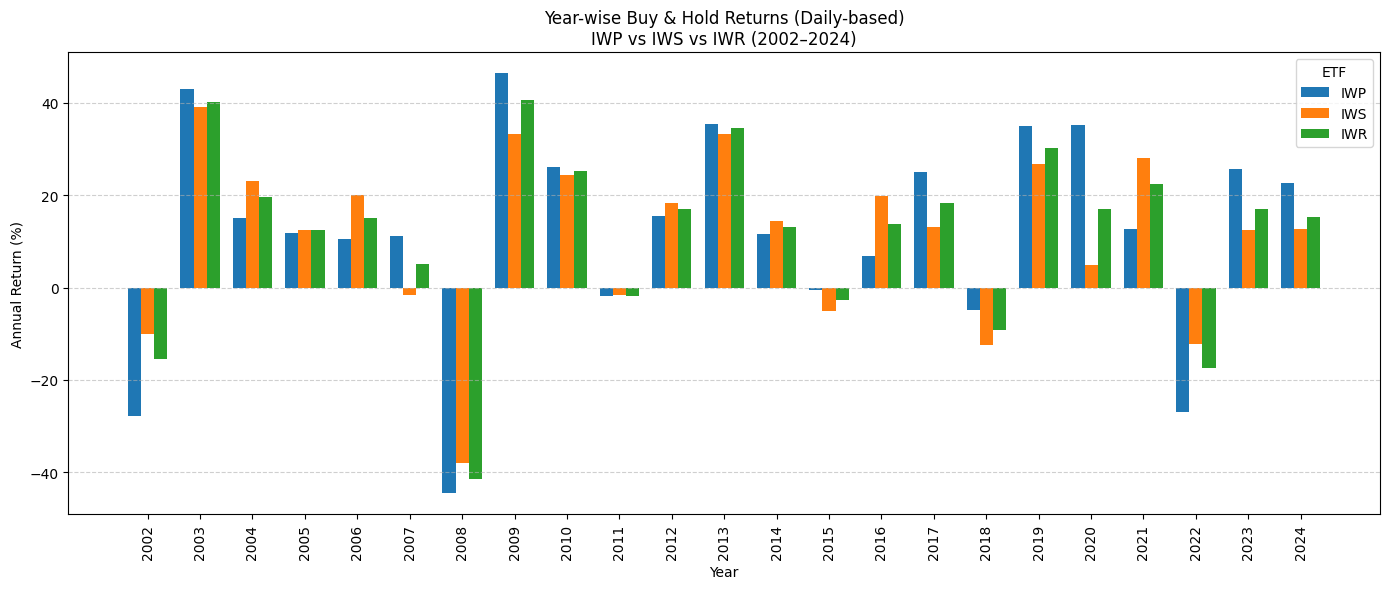

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

combined_path = Path("/content/buy_hold_daily_yearwise/IWP_IWS_IWR_daily_yearwise_2002_2024.csv")
df = pd.read_csv(combined_path)
df["Year"] = df["Year"].astype(int)

plt.figure(figsize=(14,6))
years = sorted(df["Year"].unique())
tickers = ["IWP","IWS","IWR"]
width = 0.25
for i, t in enumerate(tickers):
    d = df[df["Ticker"]==t]
    plt.bar([y + i*width for y in range(len(years))], d["Year_Return_from_days"], width=width, label=t)

plt.title("Year-wise Buy & Hold Returns (Daily-based)\nIWP vs IWS vs IWR (2002–2024)")
plt.xlabel("Year"); plt.ylabel("Annual Return (%)")
plt.xticks([y + width for y in range(len(years))], years, rotation=90)
plt.legend(title="ETF")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout(); plt.show()

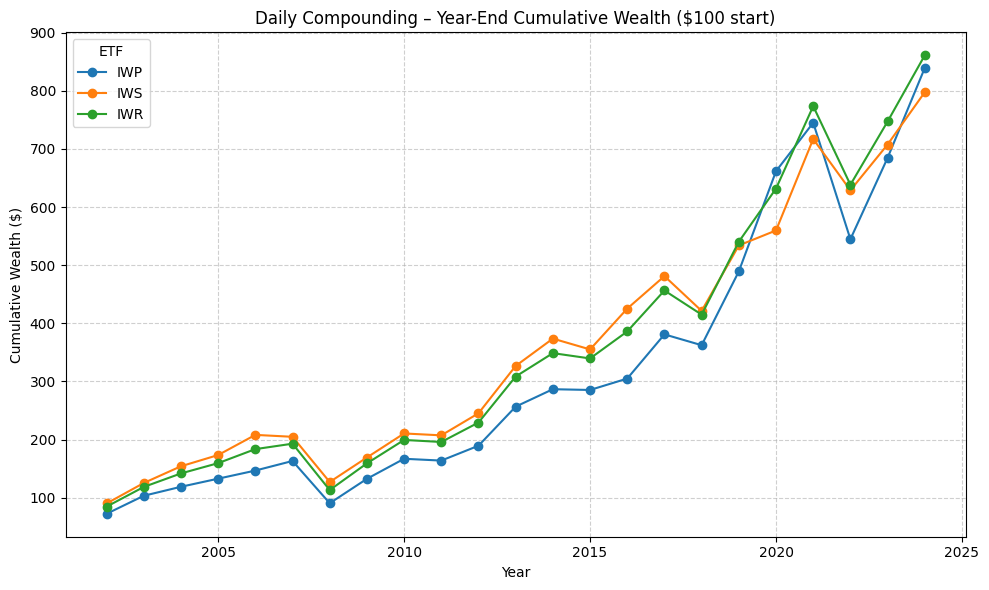

In [48]:
plt.figure(figsize=(10,6))
for t in tickers:
    d = df[df["Ticker"]==t]
    plt.plot(d["Year"], d["YearEnd_CumWealth_from_10k"], marker="o", label=t)

plt.title("Daily Compounding – Year-End Cumulative Wealth ($100 start)")
plt.xlabel("Year"); plt.ylabel("Cumulative Wealth ($)")
plt.legend(title="ETF")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout(); plt.show()
